Perform constrained optimization of linkers given node and topology

In [16]:
! pip install rdkit

Defaulting to user installation because normal site-packages is not writeable


In [17]:
import os
import re
import ast
import json
import numpy as np
import pandas as pd
from tqdm import tqdm

import rdkit.Chem.AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D

import seaborn as sns
import matplotlib.pyplot as plt

from pymatgen.core.periodic_table import Element

ModuleNotFoundError: No module named 'rdkit'

In [ ]:
font = {'family' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

output df_info

In [18]:
hMOF_dir = '/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/cifs'

In [ ]:
# output df_info

names = []
mofids = []
CO2_wc_001 = []
CO2_wc_005 = []
CO2_wc_01 = []
CO2_wc_05 = []
CO2_wc_25 = []


for hMOF in tqdm(os.listdir(hMOF_dir)):
    if '.cif' in hMOF:
        name = hMOF.split('.')[0]
        names.append(name)
        CO2_wc = json.load(open(os.path.join(hMOF_dir,name+'.json')))
        mofids.append(CO2_wc['mofid'])
        iso_therm = CO2_wc['isotherms'][0]['isotherm_data']
        for data in iso_therm:
            if data['pressure'] == 0.01:
                CO2_wc_001.append(data['total_adsorption'])
            if data['pressure'] == 0.05:
                CO2_wc_005.append(data['total_adsorption'])
            if data['pressure'] == 0.1:
                CO2_wc_01.append(data['total_adsorption'])
            if data['pressure'] == 0.5:
                CO2_wc_05.append(data['total_adsorption'])
            if data['pressure'] == 2.5:
                CO2_wc_25.append(data['total_adsorption'])
                
df = pd.DataFrame({'MOF':names,'MOFid':mofids,'CO2_wc_001':CO2_wc_001,'CO2_wc_005':CO2_wc_005,'CO2_wc_01':CO2_wc_01,'CO2_wc_05':CO2_wc_05,'CO2_wc_25':CO2_wc_25})
df.to_csv('/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/hMOF_CO2_info.csv',index=False)

remove undesired entries & collect stats

In [19]:
# cleanup
df_info = pd.read_csv('/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/hMOF_CO2_info.csv')
df_info = df_info.dropna() # drop entries containing 'NaN'
df_info = df_info[df_info.CO2_wc_001>0] # only keep entries with positive CO2 working capacity
df_info = df_info[~df_info.MOFid.str.contains('ERROR')] # drop entries with error
df_info = df_info[~df_info.MOFid.str.contains('NA')] # drop entries with NA

In [ ]:
# get node and linker information
metal_eles = ['Zn', 'Cu', 'Mn', 'Zr', 'Co', 'Ni', 'Fe', 'Cd', 'Pb', 'Al', 'Mg', 'V',
       'Tb', 'Eu', 'Sm', 'Tm', 'Gd', 'Nd', 'Dy', 'La', 'Ba', 'Ga', 'In',
       'Ti', 'Be', 'Ce', 'Li', 'Pd', 'Na', 'Er', 'Ho', 'Yb', 'Ag', 'Pr',
       'Cs', 'Mo', 'Lu', 'Ca', 'Pt', 'Ge', 'Sc', 'Hf', 'Cr', 'Bi', 'Rh',
       'Sn', 'Ir', 'Nb', 'Ru', 'Th', 'As', 'Sr']

# get a list of metal nodes & create a new column named "metal_nodes"
metal_nodes = []
organic_linkers = []
for i,mofid in tqdm(enumerate(df_info.MOFid)):
    sbus = mofid.split()[0].split('.')
    metal_nodes.append([c for c in sbus if any(e in c for e in metal_eles)][0])
    organic_linkers.append([c for c in sbus if any(e in c for e in metal_eles)==False])

df_info['metal_node'] = metal_nodes
df_info['organic_linkers'] = organic_linkers

In [49]:
unique_nodes = [n for n in list(df_info['metal_node'].unique()) if len(n)<=30] # node smiles should be shorter then 30 strings
df_info = df_info[df_info['metal_node'].isin(unique_nodes)] # filter df_info based on unique_nodes
freq = [df_info['metal_node'].value_counts()[value] for value in list(df_info.metal_node.unique())] # get frequency of unique nodes
df_freq = pd.DataFrame({'node':list(df_info.metal_node.unique()),'freq':freq})
print(df_freq)
unique_node_select = ['[Zn][Zn]', '[Cu][Cu]', '[Zn][O]([Zn])([Zn])[Zn]', '[V]'] # manually select the most occuring nodes
df_info_select = df_info[df_info['metal_node'].isin(unique_node_select)] # select df_info with node only in list(unique_node_select)
df_info_select.to_csv('df_info_metal_linker.csv',index=False)

                        node   freq
0                   [Zn][Zn]  28529
1                   [Cu][Cu]  29714
2    [Zn][O]([Zn])([Zn])[Zn]  43874
3                        [V]   5197
4                 [O][V]O[V]     46
5                  [V]1[V]O1     50
6                    [V]O[V]     32
7            [V]O[V]O[V]O[V]      1
8                       [Zn]      2
9          [V]1O[V][V]O[V]O1      1
10  F[Zn][O]([Zn])([Zn])[Zn]      1
11                 [Cu][CuH]      1
12         [Zr][O]([Zr])[Zr]      1


In [48]:
# output df for each node  to a separate csv files
for n in unique_node_select:
    df_info_select_node = df_info[df_info.metal_node == n]
    df_info_select_node.to_csv(f'/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/hMOF_by_node/{n}.csv',index=False)

pairwise plot of CO2 wc at different pressures

/tmp/ipykernel_54502/519065493.py:3: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "alpha" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/plots/pairplot.jpg',alpha=0.5,dpi=300,bbox_inches='tight')


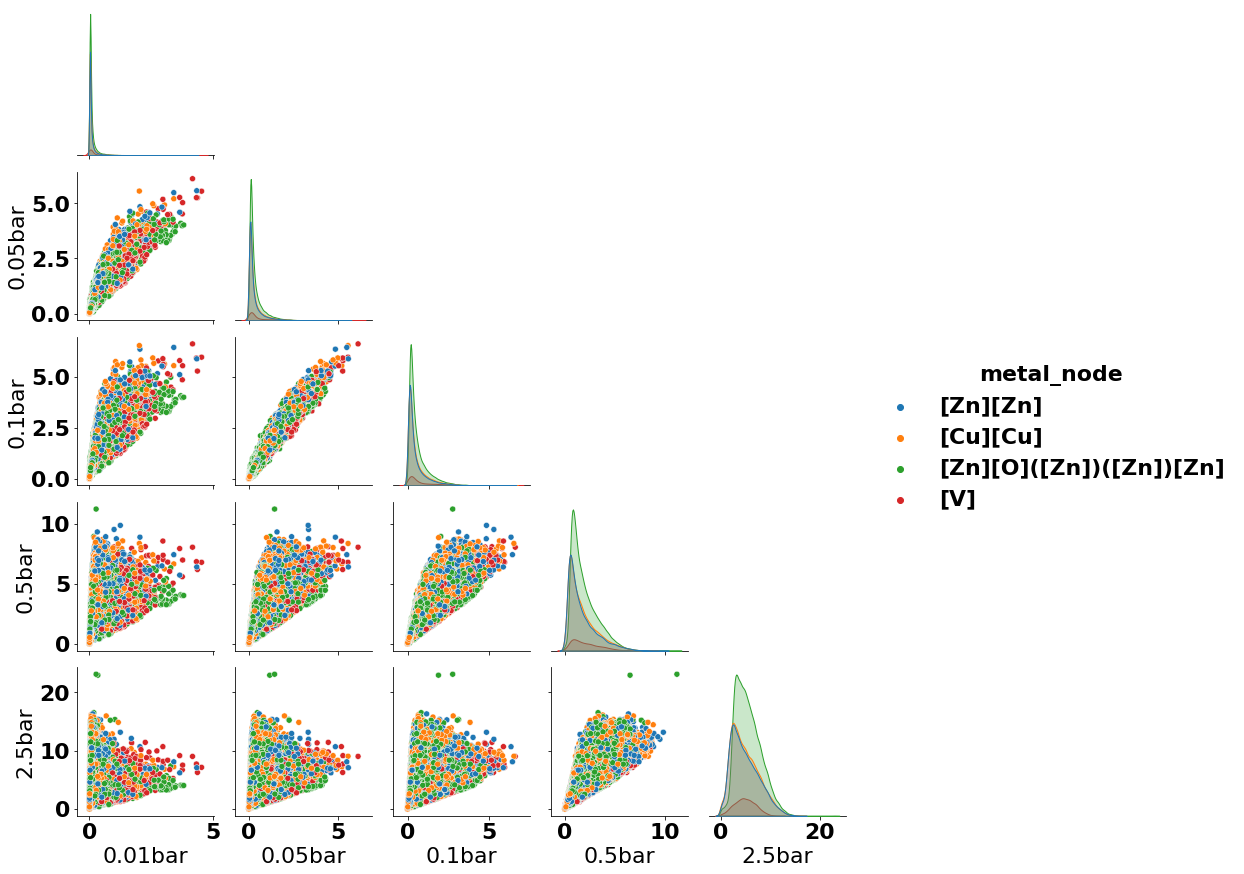

In [51]:
df_info.columns = ['MOF','MOFid','0.01bar','0.05bar','0.1bar','0.5bar','2.5bar','metal_node','organic_linkers'] # rename columns for plotting
sns.pairplot(df_info_select,hue='metal_node',corner=True)
plt.savefig('/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/plots/pairplot.jpg',alpha=0.5,dpi=300,bbox_inches='tight')

#### Constrained optimization example - Zn tetramer

Step 1 - parse linkers

In [1]:
import ast
import itertools
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tqdm'

In [ ]:
# load data

input_data_path = '/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/hMOF_by_node/[Zn][O]([Zn])([Zn])[Zn].csv' 
output_data_path = '/lus/grand/projects/ACO2RDS/ruijie/hMOF-CO2/hMOF_by_node/desired/[Zn][O]([Zn])([Zn])[Zn].csv'

df = pd.read_csv(input_data_path)

# select entries with high working capactiy
df_high_wc = df[df['0.1bar'] >=2]

# select entries with three parsed linker
len_linkers = [len(ast.literal_eval(df_high_wc['organic_linkers'].iloc[i])) for i in range(len(df_high_wc['organic_linkers']))]
df_high_wc['len_linkers'] = len_linkers
df_high_wc_select = df_high_wc[df_high_wc.len_linkers==3]
df_high_wc_select.to_csv(output_data_path,index=False)

In [14]:
# plot freq of len_linkers
'''
sns.distplot(df_high_wc.len_linkers)
plt.xticks(np.arange(min(df_high_wc.len_linkers), max(df_high_wc.len_linkers)+1, 1.0))
plt.xlim([0,7])
plt.xlabel('n_linkers_parsed')
'''

"\nsns.distplot(df_high_wc.len_linkers)\nplt.xticks(np.arange(min(df_high_wc.len_linkers), max(df_high_wc.len_linkers)+1, 1.0))\nplt.xlim([0,7])\nplt.xlabel('n_linkers_parsed')\n"

In [26]:
# get list of smiles strings for all linkers

list_smiles = [ast.literal_eval(i) for i in df_high_wc_select['organic_linkers']]
all_smiles = list(itertools.chain(*list_smiles))
print(len(all_smiles))

# output to sdf
conformer_sdf_path = '/lus/grand/projects/ACO2RDS/ruijie/DeLinker/dataset/conformers.sdf'

writer = Chem.SDWriter(conformer_sdf_path)
for smile in tqdm(all_smiles):
    try:
        mol = Chem.AddHs(Chem.MolFromSmiles(smile))
        conformers = AllChem.EmbedMultipleConfs(mol, numConfs=1)
        conformer = mol.GetConformer(0)
        for cid in range(mol.GetNumConformers()):
            writer.write(mol, confId=cid)
    except:
        pass

4164


 37%|███▋      | 1560/4164 [00:24<00:27, 93.21it/s][06:44:14] Explicit valence for atom # 14 N, 4, is greater than permitted
[06:44:14] Explicit valence for atom # 14 N, 4, is greater than permitted
100%|██████████| 4164/4164 [02:17<00:00, 30.22it/s]


In [2]:
# generate input for DiffLinker
'''
go to CLI
go to /lus/grand/projects/ACO2RDS/ruijie/DeLinker/data
change kernel to difflinker2
run the following commands
'''
python /lus/grand/projects/ACO2RDS/ruijie/DeLinker/data/prepare_data_from_sdf.py --sdf_path /lus/grand/projects/ACO2RDS/ruijie/DeLinker/dataset/conformers.sdf --output_path /lus/grand/projects/ACO2RDS/ruijie/DiffLinker_MOF/data/hMOF/output.txt --verbose

Traceback (most recent call last):
  File "/lus/grand/projects/ACO2RDS/ruijie/DeLinker/data/prepare_data_from_sdf.py", line 14, in <module>
    from rdkit import Chem
ImportError: No module named rdkit


In [7]:
# remove duplicate entries
data = open('/lus/grand/projects/ACO2RDS/ruijie/DiffLinker_MOF/data/hMOF/output.txt').readlines()
print(f'# of fragment-linker pairs: {len(data)}')
unique_data = pd.Series(data).unique()
print(f'# of unique fragment-linker pairs: {len(unique_data)}')
with open('/lus/grand/projects/ACO2RDS/ruijie/DiffLinker_MOF/data/hMOF/output_unique.txt','w+') as f:
    for line in unique_data:
        f.write(line)

# of fragment-linker pairs: 735
# of unique fragment-linker pairs: 245


In [9]:
# continue notion code!

python: can't open file 'rdkit_conf_parallel.py': [Errno 2] No such file or directory
